In [2]:
from metaflow import get_metadata, metadata

get_metadata()

# before setting actively — 'service@https://jrlr3qtbz4.execute-api.us-west-2.amazonaws.com/api/'

metadata('/Users/ceceliashao/sandbox/metaflow')

'local@/Users/ceceliashao/sandbox/metaflow'

## Metaflow for Notebook Users

Notebooks have become a critical tool for data scientists — it's super powerful to be able to write code, analyze data, and interleave visualizations, all within a single workspace. However, confidently getting a ML application to production from notebooks as a starting point presents real challenges such as:
- producing reproducible results due to environment dependencies or access to versioned artifacts like data and models
- difficulties switching easily between experimentation and deployment
- tracking and comparing different runs of your models 

#### Perhaps you've tried:
- using github repos to manage notebooks and artifacts
- using a collection of bash and Python scripts and manually checking the AWS console

Metaflow is a human-friendly Python/R library that helps data scientists and engineers build and manage real-life data science projects. By using Metaflow with your notebooks, you can develop and prototype ML applications quickly, deploy them to production, and bring them back to your prototyping environment for continuous improvement.

#### Metaflow tackles the challenges described by:
- tracking and tying versioned data and model artifacts back to the source code that they went into
- working seamlessly with distributed compute  
- managing dependencies as part of the pipeline 

<br>
< insert a diagram of how notebook and flow/tasks interact within pipeline>

## Who is this tutorial for?
This tutorial may be helpful for you if you have:
- Used notebooks for data engineering and modeling 
- Deployed notebooks to production
- General interest in how to create robust pipelines with notebooks


## What will this tutorial cover?

1. Core Metaflow Concepts
2. Best practices for managing dependencies 
3. Convert notebook into a Metaflow Flow to:
    - perform data preprocessing
    - train and evaluate a model
    - deploy the model as an endpoint 
    - and test that endpoint's performance 
4. Interact with artifacts from previous and currently running executions 

## Installing Metaflow
On your local or remote server, you can easily install metaflow by simply running:

```
pip install metaflow
```
or if you already have Metaflow installed and need to upgrade, run:

```
pip install - upgrade metaflow
```


In [12]:
! pip install metaflow 

## 101 Metaflow Concepts - Introduction to the Flow

Here's an example of a hello world Metaflow flow that prints out:

```
the data artifact is hello world
the data artifact is still hello world
```

| from the [basics of metaflow docs](https://docs.metaflow.org/metaflow/basics)

In [15]:
%%writefile metaflow101.py

from metaflow import FlowSpec, step

class LinearFlow(FlowSpec):

    @step
    def start(self):
        self.my_var = 'hello world'
        self.next(self.a)

    @step
    def a(self):
        print('the data artifact is: %s' % self.my_var)
        self.next(self.end)

    @step
    def end(self):
        print('the data artifact is still: %s' % self.my_var)

if __name__ == '__main__':
    LinearFlow()

Writing metaflow101.py


In [19]:
!python metaflow101.py --datastore=local --metadata=local run

Metaflow 2.3.6 executing LinearFlow for user:ceceliashao
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
2021-10-21 08:01:10.290 Workflow starting (run-id 1634817670279886):
2021-10-21 08:01:10.296 [1634817670279886/start/1 (pid 17428)] Task is starting.
2021-10-21 08:01:11.168 [1634817670279886/start/1 (pid 17428)] Task finished successfully.
2021-10-21 08:01:11.182 [1634817670279886/a/2 (pid 17431)] Task is starting.
2021-10-21 08:01:11.802 [1634817670279886/a/2 (pid 17431)] the data artifact is: hello world
2021-10-21 08:01:11.909 [1634817670279886/a/2 (pid 17431)] Task finished successfully.
2021-10-21 08:01:11.919 [1634817670279886/end/3 (pid 17434)] Task is starting.
2021-10-21 08:01:12.587 [1634817670279886/end/3 (pid 17434)] the data artifact is still: hello world
2021-10-21 08:01:12.721 [1634817670279886/end/3 (pid 17434)] Task finished successfully.
2021-10-21 08:01:12.722 Done!


**Expected Output:**
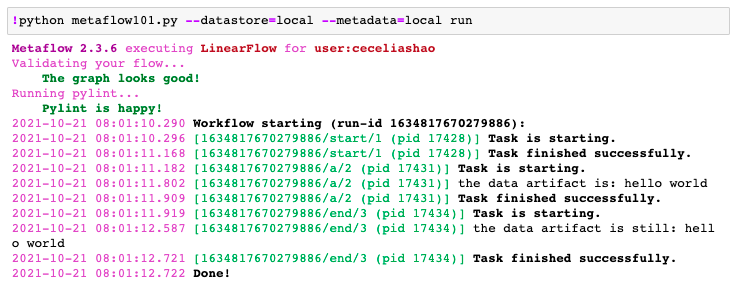

In [17]:
# https://docs.metaflow.org/metaflow/client#accessing-a-specific-object-by-its-address
from metaflow import Run

Run('LinearFlow/1634757338902184').data


<MetaflowData: my_var, name>

-----

## Notebook Version - Classifier 
In this tutorial, we will build a simple machine learning workflow for training a classifier on CIFAR10 dataset using Pytorch. This content is taken from the PyTorch tutorial ["Training a Classifier"](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

<br>

Install Pytorch through Anaconda [here](https://pytorch.org/get-started/locally)

<br> 

The steps are: 
1. **data-processing**: Download and preprocess the CIFAR10 dataset
2. **train**: Train our model
3. **test-on-test**: Test the model on the test set
4. **evaluate-model**: Test the model performance on the whole dataset

In [38]:
# # # Cell A # # # 
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# # # Cell B # # # 

#download data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
input_data_folder = "./data"
TRAIN_STEPS = 5

trainset = torchvision.datasets.CIFAR10(root=input_data_folder, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=input_data_folder, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# # # Cell C # # # 

# define model 
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# # # Cell D # # #

# Define loss func and optimizer

import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# # # Cell E # # # 

# train model

TRAIN_STEPS = 5

for epoch in range(TRAIN_STEPS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
! pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# test on snippet of test data 
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# # # Cell F # # # 

correct = 0
total = 0

#test on whole dataset 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
# # # Cell G # # # 

#accuracy by class 
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

## Converting your notebook into a Metaflow Flow
We'll go through building out this flow "step" by "step" and converting our 

#### Dependency Management
- using conda or virtualenv
- if you have a docker image 
- installing things locally 


#### Organizing imports
<br>
Since your script will run top-down, consider where you want to place your imports. If you put your imports at the very top of the script before using the `@conda` decorators, the libraries' versions may differ from the version you intend to use through that conda environment. 

<br>

- < when to put imports into a specific step >

#### Organizing steps
<br>
Again, Metaflow follows the dataflow paradigm which models a program as a directed graph of operations. The key terms to keep in mind are:

- **flow**: the graph of operations
- **step**: the operations; nodes of the graph
- **transitions**: edges between the operations (nodes) of the graph
<br>

Metaflow supports three types of transitions: linear, branch, and foreach. You can read more about each transition type in the documentation [here](https://docs.metaflow.org/metaflow/basics)

- reference what type of transition we'll be building

<br>

#### Re-usability / modularity 


## Step 1: Access Data
We are going to take our notebook cells (A + B) from above for reading in the CIFAR dataset and doing the necessary pre-processing. Then we will convert that code into the first step of our Metaflow Flow, which we'll title `ClassifierFlow`

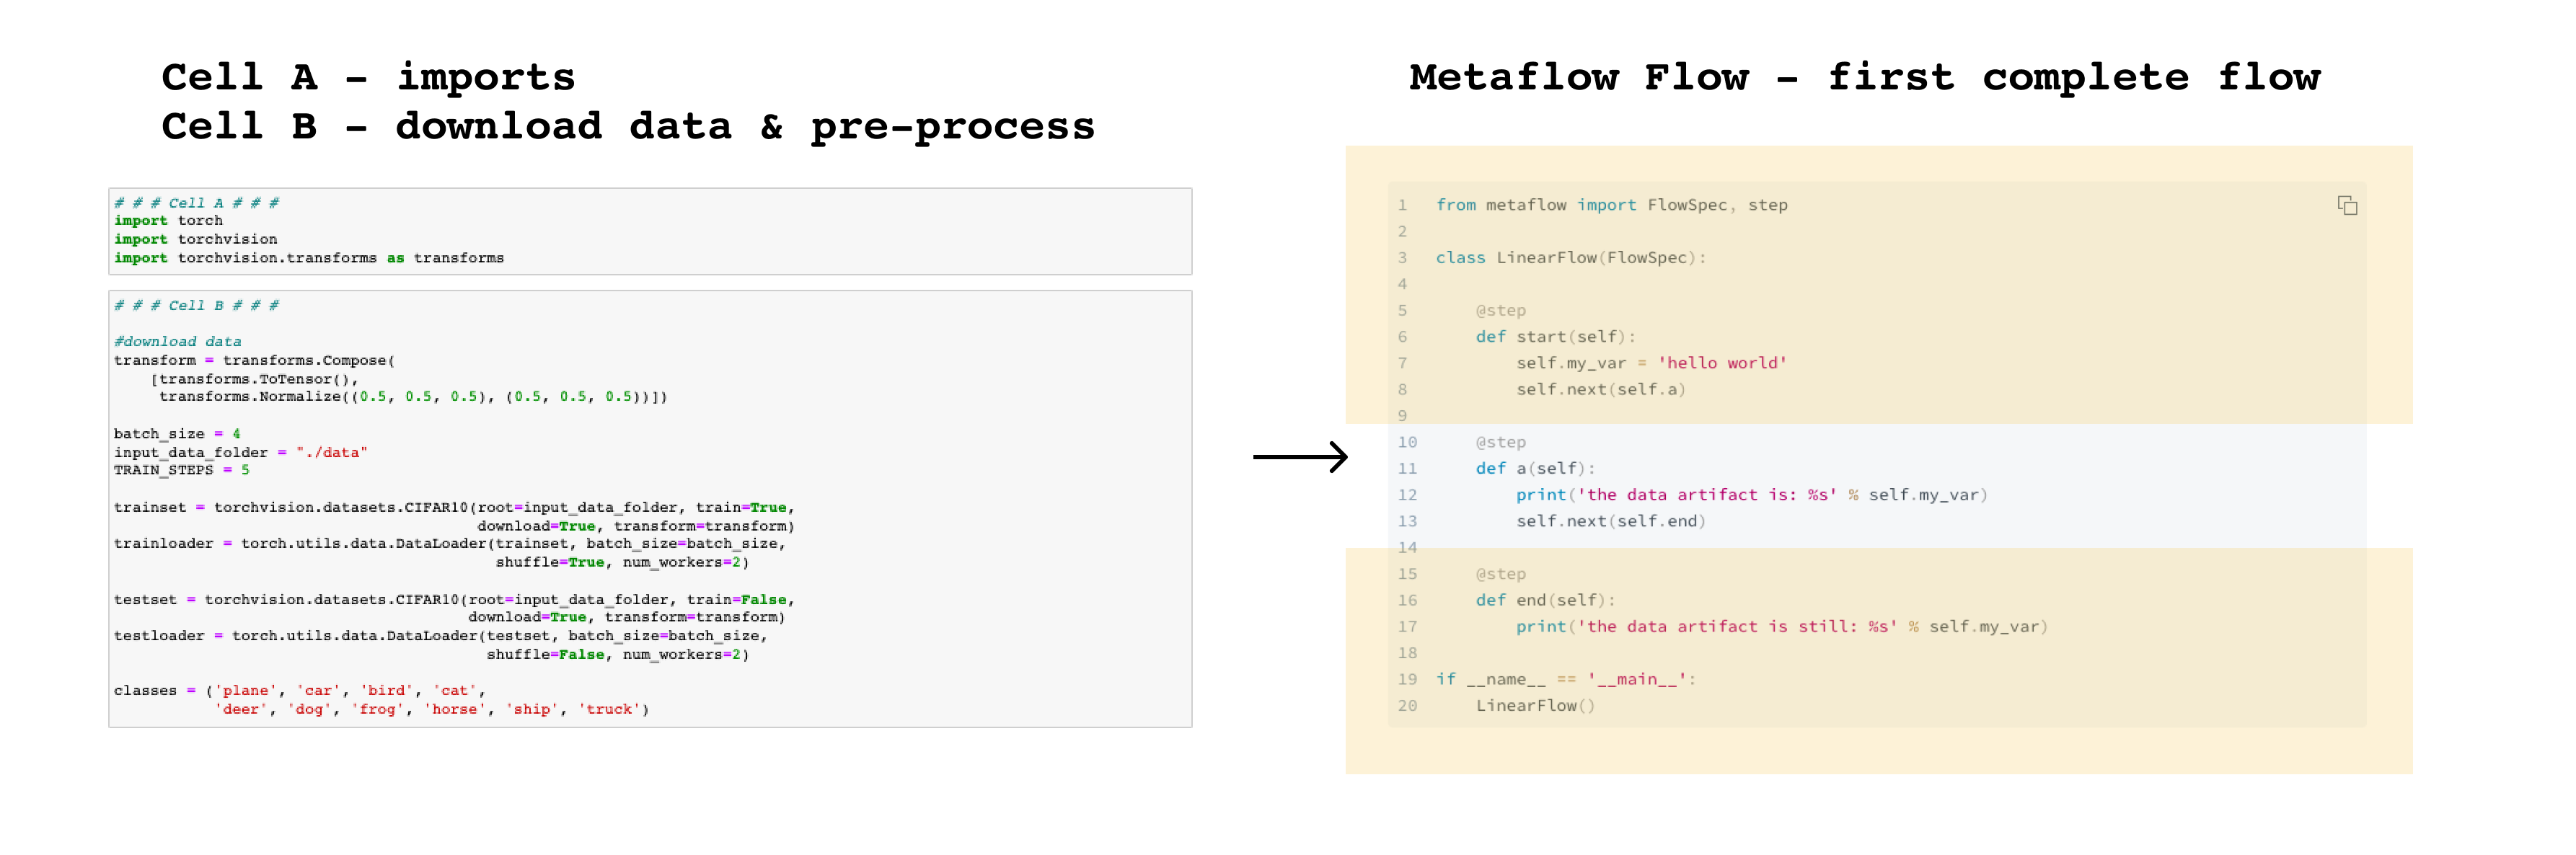

In [ ]:
%%writefile cifar_classifier.py
## `%%writefile` will create the `cifar_classifier.py` file with the following contents into your current local directory

# import key modules 
from metaflow import FlowSpec, step, conda, conda_base, namespace, Parameter 

# setting a namespace will tie your results to that namespace which helps with organization
namespace('user:cece')


class ClassifierFlow(FlowSpec):

    """
    define variables
    if you want to access the variables outside of step, use self.
    """
    batch_size = Parameter('batch_size',default=4)

    num_workers = Parameter('num_workers',default=2)

    input_data_folder = "./data"

    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    train_steps = Parameter('train_steps',default=5)
    
    @step
    def start(self):
        """
        Load the data - using torchvision to load CIFAR10
        """
        
        import torch
        import torchvision
        import torchvision.transforms as transforms
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        """
        to save or reference variables out of this step, use `self.  
        """
        self.trainset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=True,
                                        download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=self.num_workers)
        self.testset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=False,
                                       download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                         shuffle=False, num_workers=self.num_workers)
        
        # reference next step - in this case, it's the last (end) step
        self.next(self.end)
    
    
    @step
    def end(self):
        """
        End of Flow - each flow must have a end step 
        """
        print("Finished Flow")
        

if __name__ == '__main__':
    ClassifierFlow()

**Expected Output:**

`Overwriting cifar_classifier.py`

Now try running the script you just made using this command:

In [ ]:
!python cifar_classifier.py --datastore=local --metadata=local run

**Expected Output:**

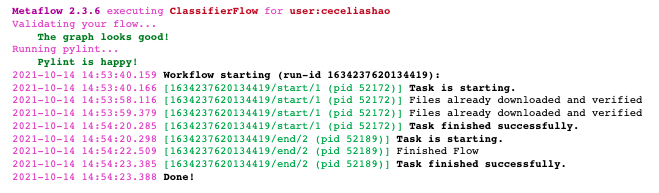


## Step 2: Define Model 
Now we are going to take our notebook cells (C) from above for defining our model and add it into our flow. We'll take a different approach with this step and create a separate module for model definition. This approach of splitting out a distinct module has two primary benefits:

1. makes the pipeline more modular. If a teammate wanted to use the same model definition, they can leverage it easily.
2. makes the metaflow flow more legible. 

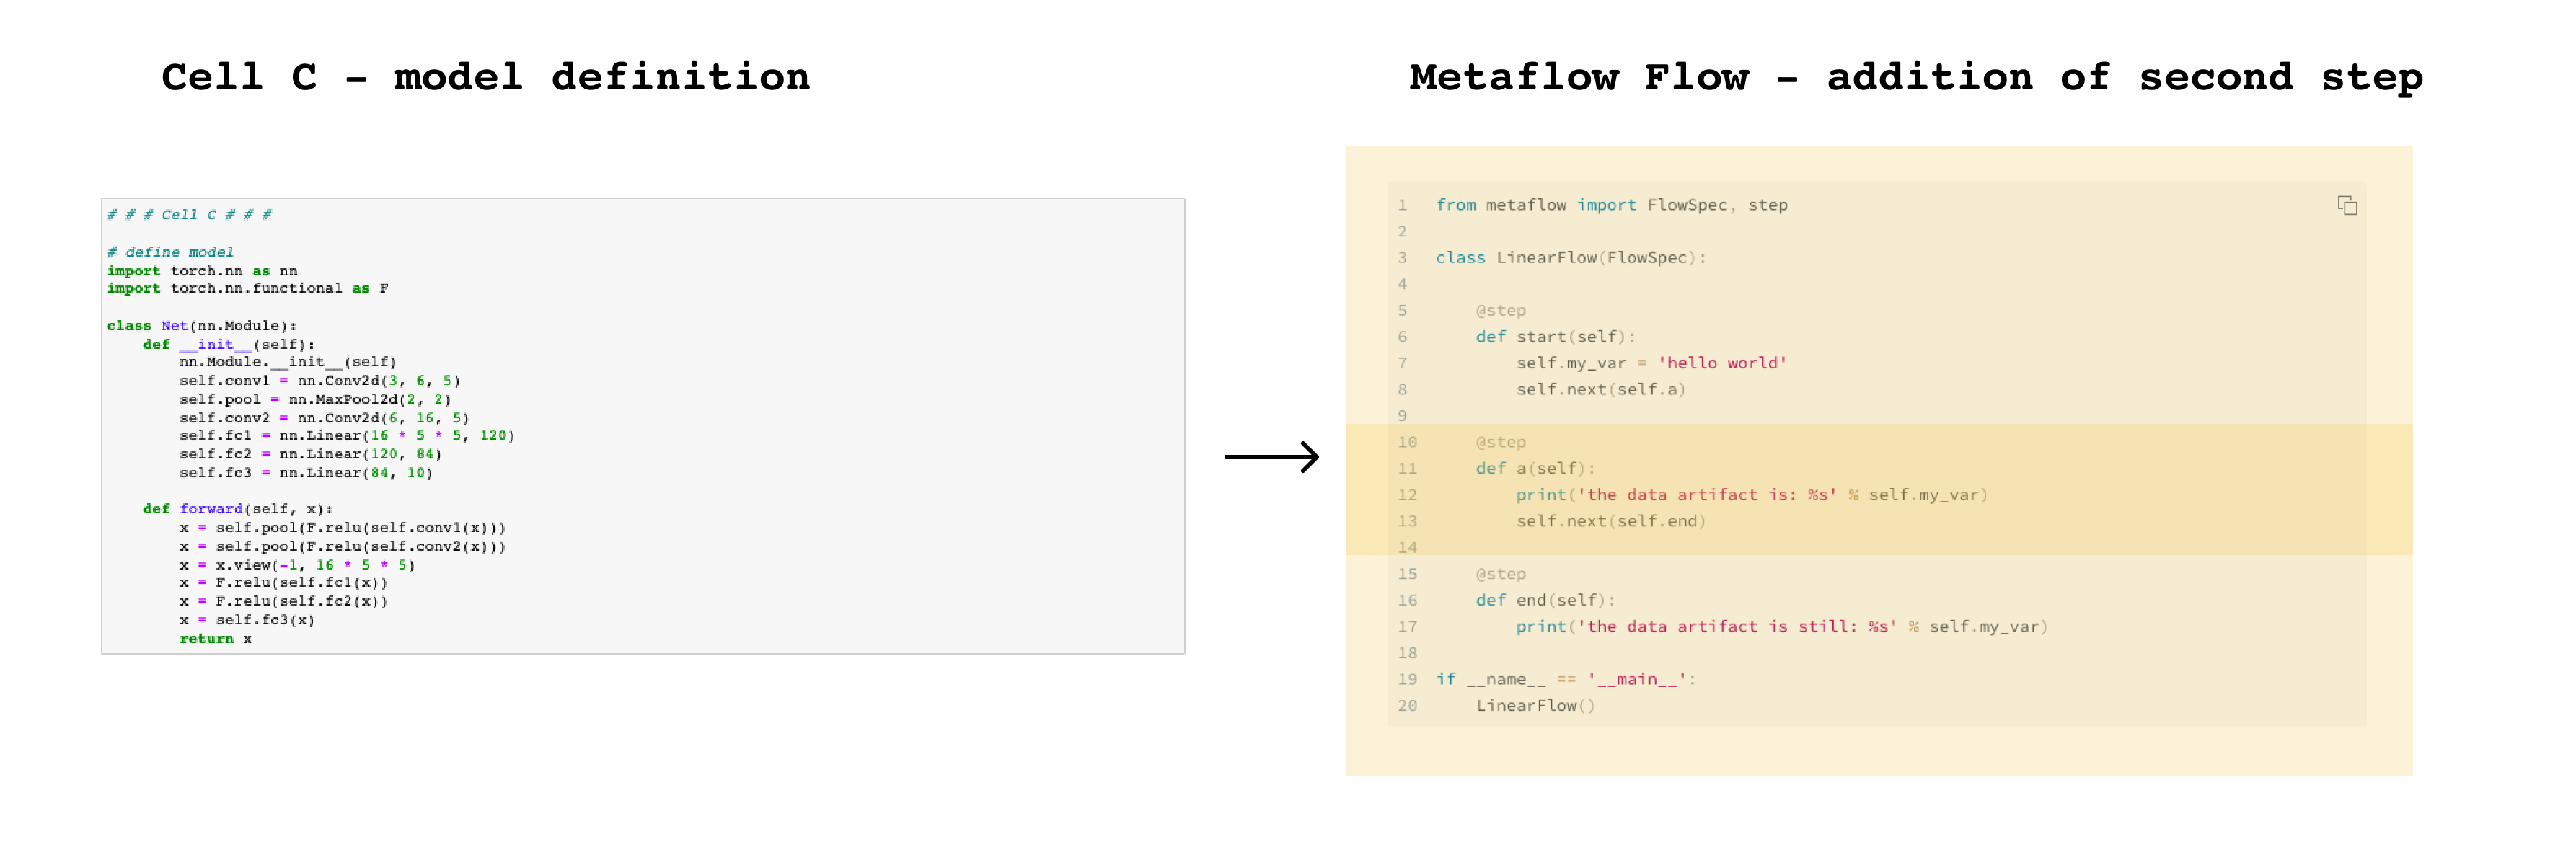

The first we'll do is use the same %%writefile magic to create the separate model definition module, like so:

In [ ]:
%%writefile classifier_model_definition.py

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):

        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Once you have the `classifier_model_definition.py` in your directory, add the import step to the 'define_model' step in the Metaflow flow.

In [ ]:
%%writefile cifar_classifier.py
## running this cell after we've created our first flow will override the existing cifar_classifier.py script from above

# import key modules 
from metaflow import FlowSpec, step, conda, conda_base, namespace, Parameter 

# setting a namespace will tie your results to that namespace which helps with organization
namespace('user:cece')


class ClassifierFlow(FlowSpec):

    """
    define variables
    if you want to access the variables outside of step, use self.
    """
    batch_size = Parameter('batch_size',default=4)

    num_workers = Parameter('num_workers',default=2)

    input_data_folder = "./data"

    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    train_steps = Parameter('train_steps',default=5)
    
    @step
    def start(self):
        """
        Load the data - using torchvision to load CIFAR10
        """
        
        import torch
        import torchvision
        import torchvision.transforms as transforms
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        """
        to save or reference variables out of this step, use `self.  
        """
        self.trainset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=True,
                                        download=True, transform=transform)
        trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=self.num_workers)
        self.testset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=False,
                                       download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                         shuffle=False, num_workers=self.num_workers)
        
        # reference next step - in this case, it's our second (define_model) step
        self.next(self.define_model)
        
    
    @step
    def define_model(self):
        """
        Since we’re now using an object instead of just using a function, we have to instantiate our model
        """
        from classifier_model_definition import Net

        self.net = Net()
        
        #print to see the structure of the model
        print(self.net)
        
        self.next(self.end)
        
    
    @step
    def end(self):
        """
        End of Flow - each flow must have a end step 
        """
        print("Finished Flow")
        

if __name__ == '__main__':
    ClassifierFlow()

Trying running the flow again:

In [ ]:
!python cifar_classifier.py --datastore=local --metadata=local run

**Expected Output:**

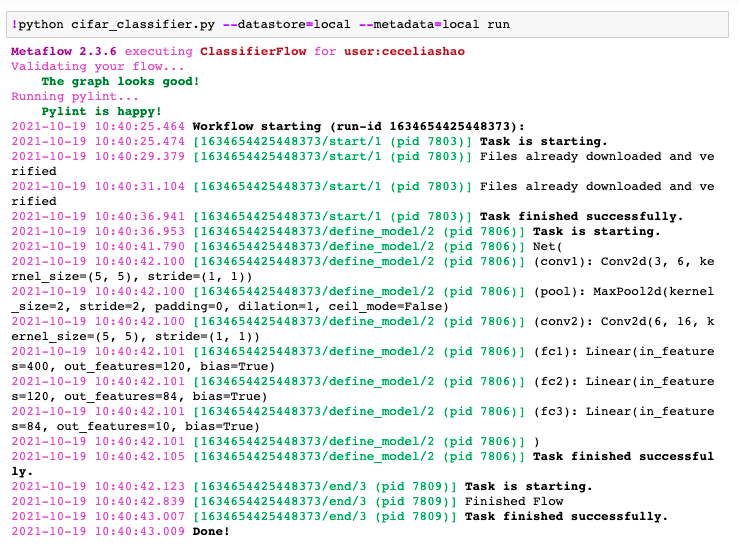

## Step 3: Train Model
Next, we are going to take our notebook cells (D + E) from above for defining the model's optimization critera and a starting set of hyperparameters then training the model and add it into our flow. 

In [20]:
%%writefile cifar_classifier.py
## running this cell after we've created our first flow will override the existing cifar_classifier.py script from above

# import key modules 
from metaflow import FlowSpec, step, conda, conda_base, namespace, Parameter 

# setting a namespace will tie your results to that namespace which helps with organization
namespace('user:cece')


class ClassifierFlow(FlowSpec):
    
    """
    define variables
    if you want to access the variables outside of step, use self.
    """
    batch_size = Parameter('batch_size',default=4)

    num_workers = Parameter('num_workers',default=2)

    input_data_folder = "./data"

    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    train_steps = Parameter('train_steps',default=5)
    
    @step
    def start(self):
        """
        Load the data - using torchvision to load CIFAR10
        """
        
        import torch
        import torchvision
        import torchvision.transforms as transforms
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        """
        again, to save or reference variables out of this step, use `self.  
        """
        self.trainset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=True,
                                        download=True, transform=transform)
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
        self.testset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=False,
                                       download=True, transform=transform)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=4,
                                         shuffle=False, num_workers=2)
        
        # reference next step - in this case, it's our second (define_model) step
        self.next(self.define_model)
        
    
    @step
    def define_model(self):
        """
        Since we’re now using an object instead of just using a function, we have to instantiate our model
        """
        from classifier_model_definition import Net

        self.net = Net()
        
        #print to see the structure of the model
        print(self.net)
        
        self.next(self.train_model)
        
    @step
    def train_model(self):
        
        import torch.nn as nn
        import torch.optim as optim
    
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        
        for epoch in range(self.train_steps):  # loop over the dataset multiple times
            
            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs
                inputs, labels = data
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
                # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        
        print('Finished Training')
        
        self.next(self.end)
    
    @step
    def end(self):
        """
        End of Flow - each flow must have a end step 
        """
        print("Finished Flow")
        

if __name__ == '__main__':
    ClassifierFlow()

Overwriting cifar_classifier.py


In [21]:
!python cifar_classifier.py --no-pylint --datastore=local --metadata=local run

Metaflow 2.3.6 executing ClassifierFlow for user:ceceliashao
Validating your flow...
    The graph looks good!
2021-10-21 10:31:19.127 Workflow starting (run-id 1634826679076942):
2021-10-21 10:31:19.140 [1634826679076942/start/1 (pid 18167)] Task is starting.
2021-10-21 10:31:25.255 [1634826679076942/start/1 (pid 18167)] Files already downloaded and verified
2021-10-21 10:31:26.620 [1634826679076942/start/1 (pid 18167)] Files already downloaded and verified
2021-10-21 10:31:34.132 [1634826679076942/start/1 (pid 18167)] Task finished successfully.
2021-10-21 10:31:34.143 [1634826679076942/define_model/2 (pid 18170)] Task is starting.
2021-10-21 10:31:39.064 [1634826679076942/define_model/2 (pid 18170)] Net(
2021-10-21 10:31:39.311 [1634826679076942/define_model/2 (pid 18170)] (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
2021-10-21 10:31:39.311 [1634826679076942/define_model/2 (pid 18170)] (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
202

## Step 4: Test Model
Next, we are going to take our notebook cell (F) which tests our model on the set of test data we held out from the CIFAR-10 dataset and add as the second-to-last step of our flow. Remember, the last step of the flow needs to be the `end` step.

In [23]:
%%writefile cifar_classifier.py
## running this cell after we've created our first flow will override the existing cifar_classifier.py script from above

# import key modules 
from metaflow import FlowSpec, step, conda, conda_base, namespace, Parameter 

# setting a namespace will tie your results to that namespace which helps with organization
namespace('user:cece')


class ClassifierFlow(FlowSpec):
    
    """
    define variables
    if you want to access the variables outside of step, use self.
    """
    batch_size = Parameter('batch_size',default=4)

    num_workers = Parameter('num_workers',default=2)

    input_data_folder = "./data"

    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    train_steps = Parameter('train_steps',default=5)
    
    @step
    def start(self):
        """
        Load the data - using torchvision to load CIFAR10
        """
        
        import torch
        import torchvision
        import torchvision.transforms as transforms
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        """
        again, to save or reference variables out of this step, use `self.  
        """
        self.trainset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=True,
                                        download=True, transform=transform)
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
        self.testset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=False,
                                       download=True, transform=transform)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=4,
                                         shuffle=False, num_workers=2)
        
        # reference next step - in this case, it's our second (define_model) step
        self.next(self.define_model)
        
    @step
    def define_model(self):
        """
        Since we’re now using an object instead of just using a function, we have to instantiate our model
        """
        from classifier_model_definition import Net

        self.net = Net()
        
        #print to see the structure of the model
        print(self.net)
        
        self.next(self.train_model)
        
    @step
    def train_model(self):
        
        import torch.nn as nn
        import torch.optim as optim
    
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        
        for epoch in range(self.train_steps):  # loop over the dataset multiple times
            
            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs
                inputs, labels = data
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
                # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        
        print('Finished Training')
        
        self.next(self.model_test)
    
    @step
    def model_test(self):
        
        import torch
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        
        self.next(self.end)
    
    @step
    def end(self):
        """
        End of Flow - each flow must have a end step 
        """
        print("Finished Flow")
        

if __name__ == '__main__':
    ClassifierFlow()

Overwriting cifar_classifier.py


In [5]:
!python cifar_classifier.py --no-pylint --datastore=local --metadata=local run

Metaflow 2.3.6 executing ClassifierFlow for user:ceceliashao
Validating your flow...
    The graph looks good!
2021-10-19 17:53:28.075 Workflow starting (run-id 1634680408037836):
2021-10-19 17:53:28.081 [1634680408037836/start/1 (pid 14259)] Task is starting.
2021-10-19 17:53:34.439 [1634680408037836/start/1 (pid 14259)] Files already downloaded and verified
2021-10-19 17:53:35.922 [1634680408037836/start/1 (pid 14259)] Files already downloaded and verified
2021-10-19 17:53:43.509 [1634680408037836/start/1 (pid 14259)] Task finished successfully.
2021-10-19 17:53:43.525 [1634680408037836/define_model/2 (pid 14262)] Task is starting.
2021-10-19 17:53:48.431 [1634680408037836/define_model/2 (pid 14262)] Net(
2021-10-19 17:53:48.707 [1634680408037836/define_model/2 (pid 14262)] (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
2021-10-19 17:53:48.707 [1634680408037836/define_model/2 (pid 14262)] (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
202

**Expected Output:**

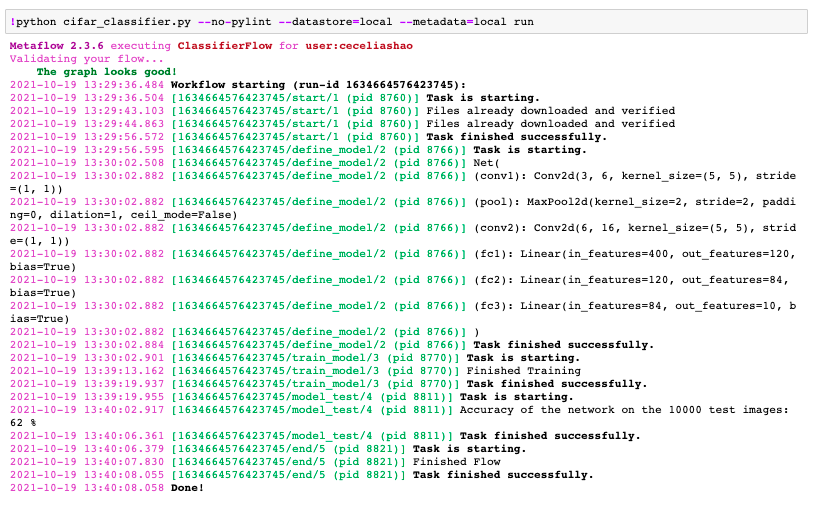

## Inspecting Metaflow Flows and Runs

Placeholder text

In [32]:
# https://docs.metaflow.org/metaflow/client#accessing-a-specific-object-by-its-address
from metaflow import Run

Run('ClassifierFlow/1634680408037836').data

<MetaflowData: trainset, net, classes, name, testloader, input_data_folder, testset, num_workers, train_steps, trainloader, batch_size>

In [42]:
from metaflow import Flow

run = Flow('ClassifierFlow').latest_run
run.data.trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [45]:
run.data.testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [46]:
run.data.net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Test: Testing different parameters 

We set all of our parameters at the top of the flow. Let's try experimenting with different values for some of our parameters to see if we can improve our model's performance.

To see the official Metaflow documentation on defining parameters, go [here](https://docs.metaflow.org/metaflow/basics#how-to-define-parameters-for-flows) 

In [27]:
%%writefile cifar_classifier_param_test.py

# import key modules 
from metaflow import FlowSpec, step, conda, conda_base, namespace, Parameter 

# setting a namespace will tie your results to that namespace which helps with organization
namespace('user:cece')


class ClassifierFlow(FlowSpec):
    
    """
    define variables
    if you want to access the variables outside of step, use self.
    """
    batch_size = Parameter('batch_size',default=4)

    num_workers = Parameter('num_workers',default=2)

    input_data_folder = "./data"

    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    train_steps = Parameter('train_steps',default=5)
    
    lr = Parameter('lr',default=0.001)
    
    momentum = Parameter('momentum',default=0.9)
    
    @step
    def start(self):
        """
        Load the data - using torchvision to load CIFAR10
        """
        
        import torch
        import torchvision
        import torchvision.transforms as transforms
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        """
        again, to save or reference variables out of this step, use `self.  
        """
        self.trainset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=True,
                                        download=True, transform=transform)
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=self.batch_size,
                                          shuffle=True, num_workers=self.num_workers)
        self.testset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=False,
                                       download=True, transform=transform)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=self.batch_size,
                                         shuffle=False, num_workers=self.num_workers)
        
        # reference next step - in this case, it's our second (define_model) step
        self.next(self.define_model)
        
    @step
    def define_model(self):
        """
        Since we’re now using an object instead of just using a function, we have to instantiate our model
        """
        from classifier_model_definition import Net

        self.net = Net()
        
        #print to see the structure of the model
        print(self.net)
        
        self.next(self.train_model)
        
    @step
    def train_model(self):
        
        import torch.nn as nn
        import torch.optim as optim
    
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr=self.lr, momentum=self.momentum)
        
        for epoch in range(self.train_steps):  # loop over the dataset multiple times
            
            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs
                inputs, labels = data
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
                # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        
        print('Finished Training')
        
        self.next(self.model_test)
    
    @step
    def model_test(self):
        
        import torch
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        
        self.next(self.end)
    
    @step
    def end(self):
        """
        End of Flow - each flow must have a end step 
        """
        print("Finished Flow")
        

if __name__ == '__main__':
    ClassifierFlow()

Overwriting cifar_classifier_param_test.py


In [29]:
!python cifar_classifier_param_test.py --no-pylint --datastore=local --metadata=local run

Metaflow 2.3.6 executing ClassifierFlow for user:ceceliashao
Validating your flow...
    The graph looks good!
2021-10-21 12:39:53.104 Workflow starting (run-id 1634834393086517):
2021-10-21 12:39:53.110 [1634834393086517/start/1 (pid 19181)] Task is starting.
2021-10-21 12:39:58.771 [1634834393086517/start/1 (pid 19181)] Files already downloaded and verified
2021-10-21 12:39:59.931 [1634834393086517/start/1 (pid 19181)] Files already downloaded and verified
2021-10-21 12:40:06.949 [1634834393086517/start/1 (pid 19181)] Task finished successfully.
2021-10-21 12:40:06.958 [1634834393086517/define_model/2 (pid 19185)] Task is starting.
2021-10-21 12:40:11.704 [1634834393086517/define_model/2 (pid 19185)] Net(
2021-10-21 12:40:11.944 [1634834393086517/define_model/2 (pid 19185)] (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
2021-10-21 12:40:11.944 [1634834393086517/define_model/2 (pid 19185)] (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
202

In [44]:
!python cifar_classifier_param_test.py --no-pylint --datastore=local --metadata=local run --train_steps 10

Metaflow 2.3.6 executing ClassifierFlow for user:ceceliashao
Validating your flow...
    The graph looks good!
2021-10-21 14:42:16.071 Workflow starting (run-id 1634841736051334):
2021-10-21 14:42:16.079 [1634841736051334/start/1 (pid 20715)] Task is starting.
2021-10-21 14:42:21.711 [1634841736051334/start/1 (pid 20715)] Files already downloaded and verified
2021-10-21 14:42:23.153 [1634841736051334/start/1 (pid 20715)] Files already downloaded and verified
2021-10-21 14:42:32.532 [1634841736051334/start/1 (pid 20715)] Task finished successfully.
2021-10-21 14:42:32.542 [1634841736051334/define_model/2 (pid 20726)] Task is starting.
2021-10-21 14:42:38.569 [1634841736051334/define_model/2 (pid 20726)] Net(
2021-10-21 14:42:39.095 [1634841736051334/define_model/2 (pid 20726)] (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
2021-10-21 14:42:39.095 [1634841736051334/define_model/2 (pid 20726)] (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
202

## Test: Putting imports at the top

In [3]:
%%writefile cifar_classifier_import_test.py
## running this cell after we've created our first flow will override the existing cifar_classifier.py script from above

# import key modules 
from metaflow import FlowSpec, step, namespace, Parameter 

# setting a namespace will tie your results to that namespace which helps with organization
namespace('user:cece')

import torch
import torchvision
import torchvision.transforms as transforms        
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class ClassifierFlow(FlowSpec):
    
    """
    define variables
    if you want to access the variables outside of step, use self.
    """
    batch_size = Parameter('batch_size',default=4)

    num_workers = Parameter('num_workers',default=2)

    input_data_folder = "./data"

    classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    train_steps = Parameter('train_steps',default=5)
    
    @step
    def start(self):
        """
        Load the data - using torchvision to load CIFAR10
        """
        
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        """
        again, to save or reference variables out of this step, use `self.  
        """
        self.trainset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=True,
                                        download=True, transform=transform)
        self.trainloader = torch.utils.data.DataLoader(self.trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
        self.testset = torchvision.datasets.CIFAR10(root=self.input_data_folder, train=False,
                                       download=True, transform=transform)
        self.testloader = torch.utils.data.DataLoader(self.testset, batch_size=4,
                                         shuffle=False, num_workers=2)
        
        # reference next step - in this case, it's our second (define_model) step
        self.next(self.define_model)
        
    
    @step
    def define_model(self):
        """
        Since we’re now using an object instead of just using a function, we have to instantiate our model
        """
        from classifier_model_definition import Net

        self.net = Net()
        
        #print to see the structure of the model
        print(self.net)
        
        self.next(self.train_model)
        
    @step
    def train_model(self):
    
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.net.parameters(), lr=0.001, momentum=0.9)
        
        for epoch in range(self.train_steps):  # loop over the dataset multiple times
            
            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs
                inputs, labels = data
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
                # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        
        print('Finished Training')
        
        self.next(self.model_test)
    
    @step
    def model_test(self):
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        
        self.next(self.end)
    
    @step
    def end(self):
        """
        End of Flow - each flow must have a end step 
        """
        print("Finished Flow")
        

if __name__ == '__main__':
    ClassifierFlow()

Overwriting cifar_classifier_import_test.py


In [10]:
!python cifar_classifier_import_test.py --datastore=local --metadata=local run

Metaflow 2.3.6 executing ClassifierFlow for user:ceceliashao
Validating your flow...
    The graph looks good!

'/Users/ceceliashao/sandbox/metaflow/cifar_classifier_import_test.py show' shows a description of this flow.
'/Users/ceceliashao/sandbox/metaflow/cifar_classifier_import_test.py run' runs the flow locally.
'/Users/ceceliashao/sandbox/metaflow/cifar_classifier_import_test.py help' shows all available commands and options.



- sample prediction (showcasing the client API and have the model artifact in the notebook
- hyperparameter optimization -> join step (evaluating some variable)

### More Resources:
- Link to article on netflix team using metaflow.client to inject results into a notebook to inspect results 
- [Debugging Metaflow Jobs](https://www.highonscience.com/blog/2021/06/02/metaflow-ml-debugging/)
- https://pythonawesome.com/an-end-to-end-implementation-of-intent-prediction-with-metaflow-and-other-cool-tools/
- [Metaflow Docs - Notebooks](https://docs.metaflow.org/metaflow-on-aws/metaflow-on-aws#notebooks)

In [ ]:
def get_python_version():
    """
    A convenience function to get the python version used to run this
    tutorial. This ensures that the conda environment is created with an
    available version of python.
    """
    import platform
    versions = {'3' : '3.6.9'}
    return versions[platform.python_version_tuple()[0]]

#@conda_base(python=get_python_version())

## [WIP - Managing dependencies]

https://docs.metaflow.org/metaflow/dependencies

The @conda decorator which allows the user to specify external dependencies for their steps safely. The @conda decorator freezes the execution environment, providing good guarantees of reproducibility, both when executed locally as well as in the cloud.

Different steps: using `@conda` ensures that a specific isolated conda environment gets created for every step of your flow.

`@conda_base` 
https://docs.metaflow.org/metaflow/dependencies#conda-tips-and-tricks

Conda 101 instructions - 
- install conda 
- start with a base installation & can create multiple conda environments

```
conda create --name ENVNAME
```
- activate conda environment

```
conda activate --name ENVNAME
```
- see your list of conda environments
```
conda env list
```

- install package into specific conda environment
```
conda install PACKAGENAME --name ENVNAME
```

- use conda environment in your notebook as kernel (via ipykernel)
 

```
python -m ipykernel install --user --name=firstEnv
```

- check the packaged inside a specific environment
```
conda list -n ENVNAME
```

If you are collaborating with someone and want to ensure they are using the same environment, you can export it as a yml file:

```
conda env export > envname.yml
```
then send your collaborator the yml file and have them build their own environment using the yml:

```
conda env create -f envname.yml
```

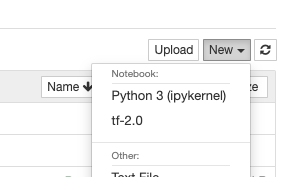